In [57]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [58]:
file_path = "playground-series-s4e12//"

df_train = pd.read_csv(file_path +"train.csv")
df_test = pd.read_csv(file_path +"test.csv")

In [59]:
df_train.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [60]:
pd.Series({c: df_train[c].unique() for c in df_train})

id                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
Age                     [19.0, 39.0, 23.0, 21.0, 29.0, 41.0, 48.0, 44....
Gender                                                     [Female, Male]
Annual Income           [10049.0, 31678.0, 25602.0, 141855.0, 39651.0,...
Marital Status                           [Married, Divorced, Single, nan]
Number of Dependents                       [1.0, 3.0, 2.0, 0.0, 4.0, nan]
Education Level                  [Bachelor's, Master's, High School, PhD]
Occupation                     [Self-Employed, nan, Employed, Unemployed]
Health Score            [22.59876067181393, 15.569730989408043, 47.177...
Location                                         [Urban, Rural, Suburban]
Policy Type                               [Premium, Comprehensive, Basic]
Previous Claims         [2.0, 1.0, 0.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ...
Vehicle Age             [17.0, 12.0, 14.0, 0.0, 8.0, 4.0, 11.0, 10.0, ...
Credit Score            [372.0, 694.0,

In [61]:
from sklearn.preprocessing import LabelEncoder

# Define the columns to encode
columns_to_encode = [
    'Gender',
    'Marital Status',
    'Education Level',
    'Occupation',
    'Location',
    'Policy Type',
    'Customer Feedback',
    'Smoking Status',
    'Exercise Frequency',
    'Property Type',
]

# Encode columns
for col in columns_to_encode:
    # Use LabelEncoder for encoding
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))  # Convert to string to handle NaN
    df_train[col] = df_train[col].astype(float)


In [62]:
#df_train.hist(figsize=(15,10), grid=False)

In [63]:
df_train = df_train.drop(['id','Policy Start Date'], axis=1)
features = df_train.drop(['Premium Amount'], axis=1)
label = df_train.pop('Premium Amount')
train_dataset = df_train.sample(frac=0.8, random_state=0)
test_dataset = df_train.drop(train_dataset.index)


In [64]:
df_train.dtypes

Age                     float64
Gender                  float64
Annual Income           float64
Marital Status          float64
Number of Dependents    float64
Education Level         float64
Occupation              float64
Health Score            float64
Location                float64
Policy Type             float64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Customer Feedback       float64
Smoking Status          float64
Exercise Frequency      float64
Property Type           float64
dtype: object

In [65]:
df_train.shape


(1200000, 18)

In [66]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"Using {device} device")

Using mps device


In [67]:
#Defining model
model = nn.Sequential(
    nn.Linear(19, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

In [68]:
class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(18, 24),
            nn.ReLU(),
            #nn.Dropout(p=0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(24, 12),
            nn.ReLU(),
            #nn.Dropout(p=0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(12, 6),
            nn.ReLU(),
            #nn.Dropout(p=0.25)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(6, 1)
        )
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [69]:
model = PyTorchModel().to(device)
print(model)

PyTorchModel(
  (layer1): Sequential(
    (0): Linear(in_features=18, out_features=24, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=24, out_features=12, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=12, out_features=6, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=6, out_features=1, bias=True)
  )
)


In [74]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, label, train_size= 0.8, shuffle=True)
epochs = 25
batch_size = 1024


In [72]:
from sklearn.preprocessing import StandardScaler


# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure target variables are numpy arrays
y_train_scaled = (y_train / y_train.max()).values  # Convert to numpy
y_test_scaled = (y_test / y_train.max()).values  # Convert to numpy

# PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32).to(device),
    torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32).to(device),
    torch.tensor(y_test_scaled, dtype=torch.float32).to(device)
)

# Use DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [75]:
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_x).squeeze()  # Squeeze if output shape needs to match labels
        loss = loss_fn(predictions, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Average loss for the epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1/25, Loss: 0.0300
Epoch 2/25, Loss: 0.0300
Epoch 3/25, Loss: 0.0300
Epoch 4/25, Loss: 0.0300
Epoch 5/25, Loss: 0.0300


KeyboardInterrupt: 

Mean Squared Error (MSE): 42425.4727
R-squared (R²): -1416340.9433


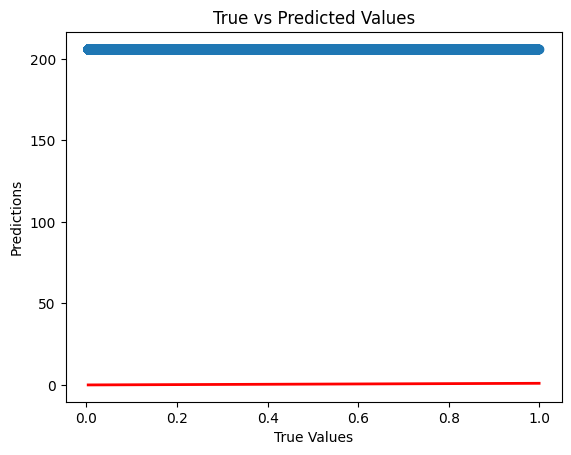

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize lists for predictions and actual values
predictions_list = []
y_test_list = []

# Disable gradient calculation
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Get predictions
        predictions = model(batch_x).squeeze()
        predictions_list.append(predictions.cpu().numpy())  # Move to CPU for compatibility
        y_test_list.append(batch_y.cpu().numpy())  # Move true labels to CPU

# Flatten lists to arrays
predictions_array = np.concatenate(predictions_list, axis=0)
y_test_array = np.concatenate(y_test_list, axis=0)

# Compute MSE and R²
mse = mean_squared_error(y_test_array, predictions_array)
r2 = r2_score(y_test_array, predictions_array)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optional: Plot predictions vs true values
plt.scatter(y_test_array, predictions_array)
plt.plot([min(y_test_array), max(y_test_array)], [min(y_test_array), max(y_test_array)], color='red', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()